In [1]:
import cv2
import numpy as np

from google.colab.patches import cv2_imshow

In [2]:
def detect_blue_cards(image_path):
    img = cv2.imread(image_path)
    if img is None:
        return None

    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)


    lower_blue = np.array([100, 100, 50])
    upper_blue = np.array([255, 255, 255])
    mask = cv2.inRange(hsv, lower_blue, upper_blue)

    contours, _ = cv2.findContours(mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    detected_cards = []
    for i, cnt in enumerate(contours):
        area = cv2.contourArea(cnt)
        if area < 3000:
            continue

        epsilon = 0.07 * cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, epsilon, True)
        sides = len(approx)

        x, y, w, h = cv2.boundingRect(approx)
        aspect_ratio = max(w,h)/min(w,h) if min(w,h) > 0 else 0

        if (4 <= sides <= 8) and (0.5 < aspect_ratio < 2.5):
            detected_cards.append(approx)

    result = img.copy()
    cv2.drawContours(result, detected_cards, -1, (0,255,0), 3)

    return result

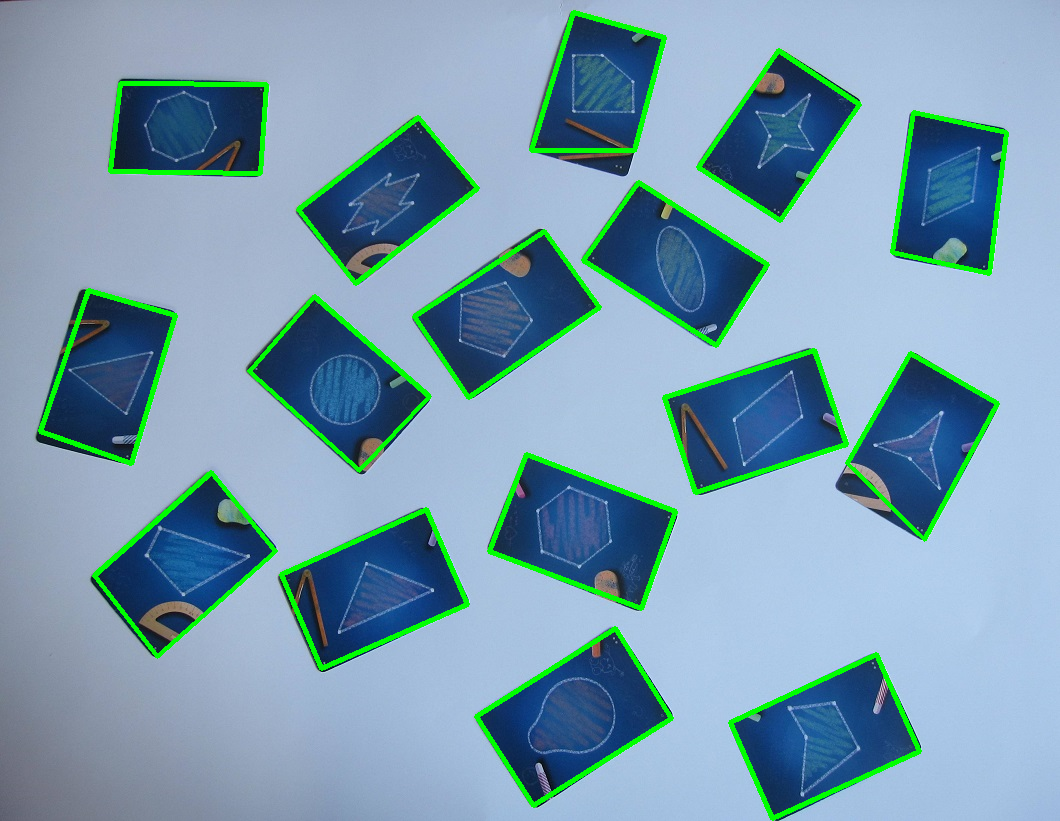

In [3]:
result_image = detect_blue_cards("IMG_1.jpg")
cv2_imshow(result_image)

In [97]:
THRESHOLDS = list(range(250, 30, -10))

def process_shape(card_roi, original_img, card_contour):
    gray = cv2.cvtColor(card_roi, cv2.COLOR_BGR2GRAY)
    stop_flag = False
    good_iter = False

    for threshold in THRESHOLDS:
        if stop_flag:
            break
        _, mask = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY)

        corner_size = 50
        border_size = 15
        h, w = mask.shape[:2]
        corners = [
            np.array([[0, 0], [corner_size, 0], [0, corner_size]]),
            np.array([[w, 0], [w - corner_size, 0], [w, corner_size]]),
            np.array([[0, h], [0, h - corner_size], [corner_size, h]]),
            np.array([[w, h], [w, h - corner_size], [w - corner_size, h]])
        ]

        for triangle in corners:
            cv2.fillPoly(mask, [triangle], (0, 0, 0))

        cv2.rectangle(mask, (0, 0), (w, border_size), (0, 0, 0), -1)
        cv2.rectangle(mask, (0, h - border_size), (w, h), (0, 0, 0), -1)
        cv2.rectangle(mask, (0, 0), (border_size, h), (0, 0, 0), -1)
        cv2.rectangle(mask, (w - border_size, 0), (w, h), (0, 0, 0), -1)

        mask = cv2.GaussianBlur(mask, (5, 5), 0)
        mask = cv2.GaussianBlur(mask, (5, 5), 0)

        contours, _ = cv2.findContours(mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
        if not contours:
            continue

        for contour in contours:
            epsilon = 0.03 * cv2.arcLength(contour, True)
            approx = cv2.approxPolyDP(contour, epsilon, True)
            vertices = len(approx)

            (x, y), radius = cv2.minEnclosingCircle(contour)

            if 2 < vertices < 11 and 2000 < cv2.contourArea(contour) < 5000 and w * 0.35 < x < w * 0.65 and h * 0.35 < y < h * 0.65:
                if good_iter:
                    stop_flag = True
                else:
                    good_iter = True
                break


    if stop_flag:
        is_convex = cv2.isContourConvex(approx)

        hull = approx
        mask = np.zeros_like(card_roi)
        cv2.drawContours(mask, [hull], -1, (255,255,255), -1)

        x_offset, y_offset, _, _ = cv2.boundingRect(card_contour)
        hull_global = hull + (x_offset, y_offset)

        cv2.drawContours(original_img, [hull_global], -1, (255, 0, 0), 2)

        label = f"P{vertices}C" if is_convex else f"P{vertices}"
        cv2.putText(original_img, label, (x_offset + 10, y_offset + 30),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)

def detect_blue_cards(image_path):
    img = cv2.imread(image_path)
    if img is None:
        return None

    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)


    lower_blue = np.array([100, 100, 50])
    upper_blue = np.array([255, 255, 255])
    mask = cv2.inRange(hsv, lower_blue, upper_blue)

    contours, _ = cv2.findContours(mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    detected_cards = []
    for i, cnt in enumerate(contours):
        area = cv2.contourArea(cnt)
        if area < 3000:
            continue

        epsilon = 0.07 * cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, epsilon, True)
        sides = len(approx)

        x,y,w,h = cv2.boundingRect(approx)
        aspect_ratio = max(w, h) / min(w, h) if min(w, h) > 0 else 0

        if (4 <= sides <= 8) and (0.5 < aspect_ratio < 2.5):
            detected_cards.append(approx)
            card_roi = img[y:y+h, x:x+w]
            process_shape(card_roi, img, cnt)

    result = img.copy()
    cv2.drawContours(result, detected_cards, -1, (0, 255, 0), 3)

    return result

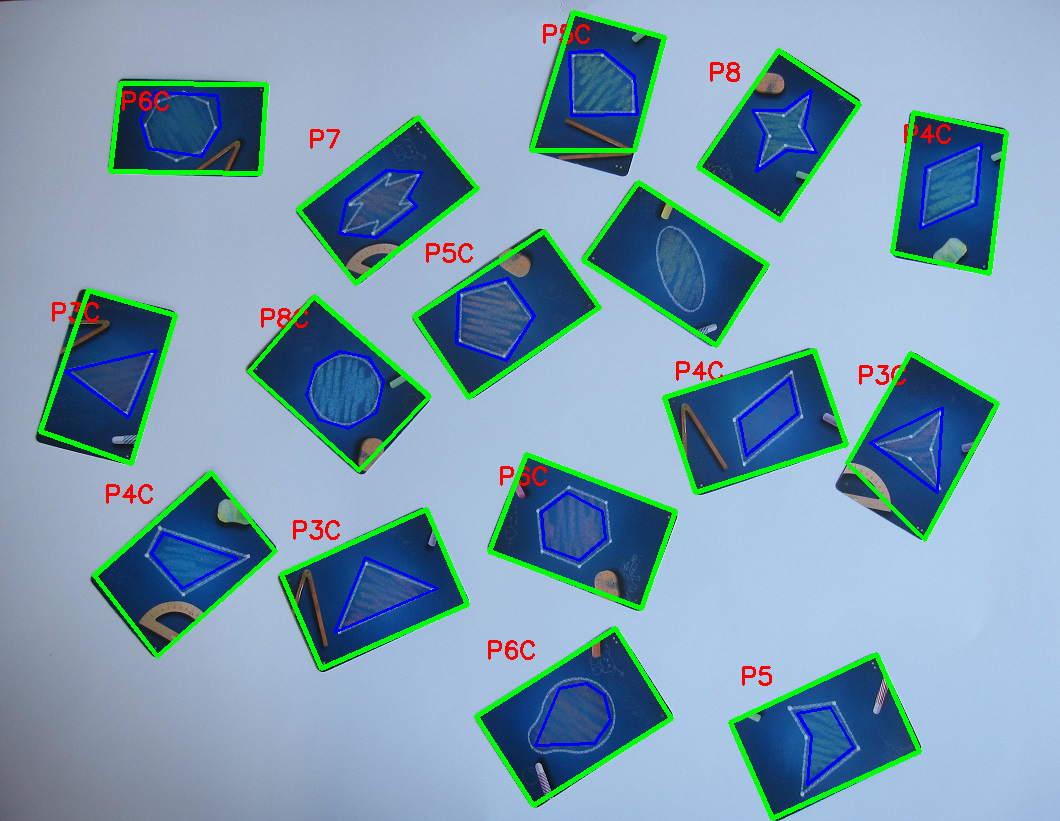

In [98]:
result = detect_blue_cards("IMG_1.jpg")
if result is not None:
    cv2_imshow(result)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [ ]:
|